In [64]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetBidimensionalNãoLinearmenteSeparável(n=20, n_classes=3):
    """
    Cria um dataset bidimensional multiclasse não linearmente separável.
    """
    X, y = make_blobs(n_samples=n, centers=n_classes*2, cluster_std=0.8)
    y = np.array(y%n_classes, dtype=int)
    return X, y

X, y = criaDatasetBidimensionalNãoLinearmenteSeparável(1000)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

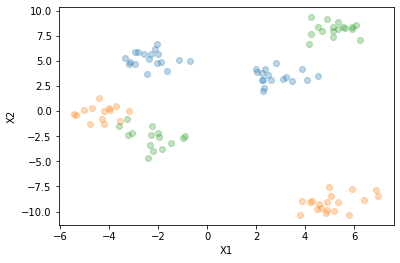

In [65]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

In [66]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [67]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [68]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [69]:
from scipy.special import expit

def tanh(a):
    return expit(a)*2-1

from abc import ABC, abstractstaticmethod

class ActivationFunction(ABC):
    @abstractstaticmethod
    def forward(a):
        pass
    @abstractstaticmethod
    def backward(a):
        pass
    @abstractstaticmethod
    def decision(a):
        pass


class Tanh(ActivationFunction):
    @staticmethod
    def forward(a):
        return expit(a) * 2 - 1
    @staticmethod
    def backward(a):
        return (1 - np.square(Tanh.forward(a)))
    @staticmethod
    def decision(a):
        return (a >= 0) * 2 - 1


class Sigmoid(ActivationFunction):
    @staticmethod
    def forward(a):
        return expit(a)
    @staticmethod
    def backward(a):
        return Sigmoid.forward(a) * (1 - Sigmoid.forward(a))
    @staticmethod
    def decision(a):
        return (a >= 0.5) * 2 - 1

In [70]:
def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X), axis=1)
    return Xb

class Backpropagation():
    def __init__(self, max_iter=1000, n_hidden=[5], activation=Tanh()):
        self.n_hidden = n_hidden
        self.activation = activation
        self.learning_rate = 0.005
        self.max_iter = max_iter
    
    def forward(self, X):
        self.A = []
        self.Z = []
        A = X.copy()
        for i in range(len(self.n_hidden)+1):
            self.A.append(includebias(A))
            self.Z.append(self.A[-1] @ self.Ws[i])
            A = self.activation.forward(self.Z[-1])
        self.ypred = self.activation.decision(A)

    def backward(self, y):
        deltas = [y - self.ypred]
        grads = [self.A[-1].T @ deltas[-1]]
        for i in range(len(self.n_hidden), 0, -1):
            deltas.insert(0, (deltas[0] @ self.Ws[i][1:,:].T) * self.activation.backward(self.Z[i-1]))
            grads.insert(0, self.A[i-1].T @ deltas[0])
        for i in range(len(self.n_hidden), -1, -1):
            self.Ws[i] += grads[i] * self.learning_rate
    
    def fit(self, X, y):
        self.Ws = []
        if len(self.n_hidden) == 0:
            self.Ws.append(np.random.uniform(-1, 1, size=(X.shape[1]+1, y.shape[1])))
        else:
            self.Ws.append(np.random.uniform(-1, 1, size=(X.shape[1]+1, self.n_hidden[0])))
            for i, _ in enumerate(self.n_hidden):
                if i == len(self.n_hidden)-1 :
                    self.Ws.append(np.random.uniform(-1, 1, size=(self.n_hidden[i]+1, y.shape[1])))
                else:
                    self.Ws.append(np.random.uniform(-1, 1, size=(self.n_hidden[i]+1, self.n_hidden[i+1])))
        for _ in range(self.max_iter):
            self.forward(X)
            self.backward(y)
    
    def predict(self, X):
        self.forward(X)
        return self.ypred

In [71]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class MLP(BaseEstimator, ClassifierMixin):
    """
    Versão do MLP com várias camadas.
    """
    def __init__(self, training_algorithm=Backpropagation()):
        self.training_algorithm = training_algorithm

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1

    def fit(self, X, y):
        yhot = self.encode_labels(y)
        self.training_algorithm.fit(X, yhot)

    def predict(self, X):
        a = self.training_algorithm.predict(X)
        if len(self.labels) <= 2:
            idx = np.array(a > 0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1) 
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

0.99
0.9877777777777778


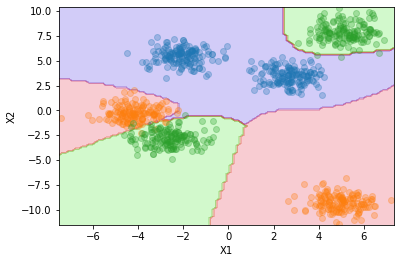

[[ 1.1202618   0.84107424  0.1942482   0.31410938 -0.67184314]
 [-0.01363916 -0.65311267 -0.58128229 -1.1588842   0.83649112]
 [-0.37747809  0.94287786  0.7537902   0.19555034  1.15517616]]
[[-0.11566665 -0.62497236 -0.99707972 -0.07425871]
 [ 0.44773889  0.13625394 -2.21485141 -0.04888286]
 [-1.23431838 -1.32873196  0.33109686 -1.36271339]
 [-0.0370763  -1.55304184  0.74824427 -1.71198785]
 [ 0.37454674  1.14285908 -1.55452614 -2.03555021]
 [-1.97326024 -0.56000541 -0.03240691 -0.53209399]]
[[ 0.35410603  0.04132003 -0.45191825]
 [-1.41872259  0.4342011   0.78062005]
 [-0.46183893 -1.28809887  0.79811403]
 [-0.84151337 -0.85120307  1.41461577]
 [-0.04749752  0.95001851 -0.95843828]]


In [72]:
mlp = MLP(Backpropagation(2000, [5,4], activation=Sigmoid()))
mlp.fit(Xtr, ytr)
print(accuracy(ytr, mlp.predict(Xtr)))
print(accuracy(yte, mlp.predict(Xte)))
plotaDatasetBidimensional(Xte, yte)
plot_predictions(mlp, Xte)
plt.show()
for i in range(len(mlp.training_algorithm.Ws)):
    print(mlp.training_algorithm.Ws[i])